In [1]:
import requests
import numpy as np
from multiprocessing import Pool
import pandas as pd
from astropy.io import fits
import groupcat
import h5py
from glob import glob
import matplotlib.pylab as plt

In [5]:
ill = pd.read_csv('/scratch/lzanisi/pixel-cnn/data/df_ill_ordered_Mgt9.5_skysub_orig.csv',sep=' ')

In [3]:
ppp = pd.read_csv('Illustris_cat_morpho.csv')

In [2]:
def get(path,params=None):
    # make HTTP GET request to path
    headers = {"api-key":"b47d28db2d6a0a93e7b0c282998f4818"}
    r = requests.get(path, params=params, headers=headers)
    # raise exception if response code is not HTTP SUCCESS (200)
    r.raise_for_status()
    id = int(path.split('/')[-1])
    if r.headers['content-type'] == 'application/json':
        mstar = np.log10(r.json()['mass_stars'])+10-np.log10(0.704)
        sfr = np.log10(r.json()['sfrinrad'])
        censat = r.json()['primary_flag']
        link_to_parent = r.json()['related']['parent_halo']
        p = requests.get(link_to_parent, headers=headers)
        if p.headers['content-type'] == 'application/json':
            link_new = p.json()['meta']['info']
            q = requests.get(link_new, headers=headers)
            dm =  q.json()['Group_M_Mean200']
            ParentDM = np.log10(dm)+10-np.log10(0.704)
        else:
            raise ValueError('bla')
        return  mstar, sfr,ParentDM,censat,id # parse json responses automatically
    if 'content-disposition' in r.headers:
        filename = r.headers['content-disposition'].split("filename=")[1]
        with open(filename, 'wb') as f:
            f.write(r.content)
        return filename,np.nan # return the filename string
    return r, np.nan

In [3]:
! wc -l filename_Illustris1.txt

14721 filename_Illustris1.txt


In [4]:
names = np.loadtxt('filename_Illustris1.txt', dtype=str)

l = lambda x: 'http://www.illustris-project.org/api/Illustris-1/snapshots/131/subhalos/'+x.split('/')[-1].split('_')[1]
Names = np.array(list(map(l, names)))

In [5]:
with Pool() as pool:
    mstar,sfr, Mhalo,censat,ids = zip(*pool.map( get,Names))

/scratch/lzanisi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/scratch/lzanisi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/scratch/lzanisi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/scratch/lzanisi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/scratch/lzanisi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/scratch/lzanisi/anaconda3/lib/python3.6/site-packages/ipykernel_

In [6]:
ids = np.array(ids)
mstar = np.array(mstar)
Mhalo = np.array(Mhalo)
censat= np.array(censat)
sfr = np.array(sfr)

In [7]:
Illustris1_df = pd.DataFrame({'SFR':sfr,'Mhalo':Mhalo,'LCentSat':censat,'objid':ids})

In [9]:
basepath = '/scratch/lzanisi/pixel-cnn/Illustris1/StellarMasses/'
names = glob(basepath+'/Subhalo_3DStellarMasses_131.hdf5')
names

dic = {}

for n in names:
    with h5py.File(n, 'r') as f:
    # List all groups
    #print("Keys: %s" % f.keys())
    #a_group_key = list(f.keys())[0]
        f = f['Subhalo']#['StellarMasses_in_r30pkpc']
    
        for key in f.keys():
    ## Get the data
            if key=='StellarMasses_in_r30pkpc' or key=='Done':
                dic[key] = np.array(list(f[key]))
    #    dic[key] = np.array(list(f[key]))




In [12]:
dic['objid'] = np.arange(len(dic['Done']))
df = pd.DataFrame(dic)
df['StellarMasses_in_r30pkpc'] = df['StellarMasses_in_r30pkpc'].apply(np.log10)

Illustris1_df = Illustris1_df.merge(df,on='objid') # merge df with correct stellar mass definition


In [13]:
Illustris1_df = Illustris1_df.rename(columns={'StellarMasses_in_r30pkpc':'Mstar'})

In [14]:
import h5py
import numpy as np
filename = 'Illustris_snap131_morphs_sdss_r.hdf5'

dic = {}
with h5py.File(filename, 'r') as f:
    # List all groups
    #print("Keys: %s" % f.keys())
    #a_group_key = list(f.keys())[0]
    for key in f.keys():
    # Get the data
        dic[key] = np.array(list(f[key]))
    



In [15]:
df = pd.DataFrame(dic)
df = df[['subfind_id','asymmetry', 'concentration','flag_sersic','gini','m20','sersic_rhalf','sersic_n']]
df = df.rename(columns={'subfind_id':'objid'})
Illustris1_df_ = Illustris1_df.merge(df,on='objid') # merge with morphologies

In [18]:
Illustris1_df_.shape

(14721, 13)

In [19]:
Illustris1_df_.to_csv('Illustris1_cat.csv', index=False) #save

In [57]:
d = pd.read_csv('Illustris1_cat.csv')

Populating the interactive namespace from numpy and matplotlib


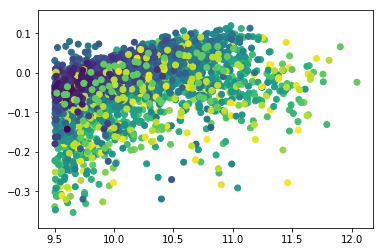

In [85]:
import matplotlib.pylab as plt
%pylab inline
m = np.ma.masked_equal(censat,0).mask
plt.scatter(mstar[m],sfr[m]/mstar[m],c=Mhalo[m])

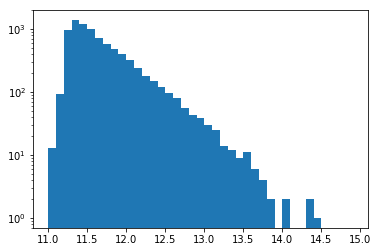

In [81]:
plt.hist(Mhalo[m], bins=np.arange(11,15,0.1))
plt.yscale('log')

In [61]:
with open('0.045_processed_asinh_Mgt10.pkl','rb') as f:
    dic = pkl.load(f)

In [63]:
len(dic['data'])

6506

In [29]:
with open('../TNG_cutouts/0.045_skysub.pkl','rb') as f:
    obj = pkl.load(f)


In [30]:
data = np.asarray(obj['data'])
objid = np.asarray(obj['objid'])

In [25]:
data[0], objid[0]

(array([[0.00896749, 0.00590875, 0.01795824, ..., 0.02577988, 0.02436856,
         0.01673994],
        [0.00364827, 0.01815149, 0.02430975, ..., 0.01861359, 0.03350756,
         0.02430975],
        [0.01758855, 0.0144713 , 0.01794144, ..., 0.03349076, 0.01782381,
         0.02299919],
        ...,
        [0.01994108, 0.03260889, 0.02781276, ..., 0.01921012, 0.0186304 ,
         0.0182187 ],
        [0.0158409 , 0.02713235, 0.03960431, ..., 0.02162979, 0.01768937,
         0.00464826],
        [0.0173701 , 0.00779106, 0.01588291, ..., 0.01726927, 0.02900556,
         0.00344659]]), 0)

In [26]:
with open('../TNG_cutouts/0.045_skysub_orig.pkl','rb') as f :
    obj = pkl.load(f)
data_orig = np.asarray(obj['data'])
objid_orig = np.asarray(obj['objid'])

In [32]:
np.any(data_orig-data!=0)

False

In [31]:
np.shape(data), np.shape(data_orig)

((6431, 128, 128), (6431, 128, 128))